In [1]:
import lake_model as lm
import matplotlib.pyplot as plt
import numpy as np
import sympy as smp
import pandas as pd

plt.style.use("ggplot")

# TPKALK analytical solution

## 1. Numerical solution

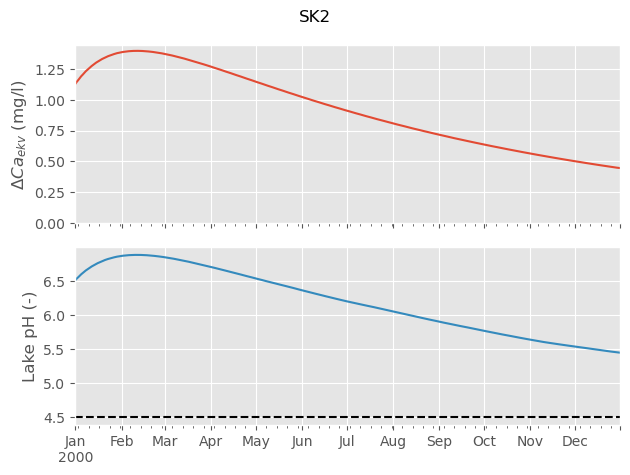

In [2]:
lake = lm.Lake(flow_prof="none")
# prod = lm.LimeProduct(
#     "Test",
#     from_database=False,
#     ca_pct=40,
#     mg_pct=0,
#     dry_fac=0.7,
#     col_depth=5,
#     id_list=(50,) * 5,
#     od_list=(1,) * 5,
# )
prod = lm.LimeProduct("SK2")
model = lm.Model(lake, prod, n_months=12, K_L=1, F_sol=1)
model.plot_result()

## 2. Solve analytically

To allow for variable times, we still need to run in a loop over each month to get the initial condition. However, we only need 12 steps per year and the result is exact.

In [3]:
# Define symbols and the function C(t), which is what we're interested in
C_inst0, t, tau, K_L, C_bott0 = smp.symbols(
    "C_inst0 t tau K_L C_bott0", nonnegative=True
)
C = smp.symbols("C", cls=smp.Function)

# Define the equation. Sympy is easiest if this is rearranged as XXXXX = 0
diffeq = smp.Eq(C(t).diff(t) - K_L * C_bott0 * smp.exp(-K_L * t) + (C(t) / tau), 0)
diffeq

Eq(-C_bott0*K_L*exp(-K_L*t) + Derivative(C(t), t) + C(t)/tau, 0)

In [4]:
# Pass the LHS and solve for C(t) with initial condition C=C_inst0 at t=0
res = smp.dsolve(diffeq.lhs, C(t), ics={C(0): C_inst0}).simplify()

# Check that the solution is correct
assert smp.checkodesol(diffeq, res)[0]

res

Eq(C(t), (-C_bott0*K_L*tau*exp(t/tau) + (C_bott0*K_L*tau + C_inst0*K_L*tau - C_inst0)*exp(K_L*t))*exp(-t*(K_L*tau + 1)/tau)/(K_L*tau - 1))

In [5]:
# Convert to function
f = smp.lambdify((t, C_inst0, tau, K_L, C_bott0), res.rhs)

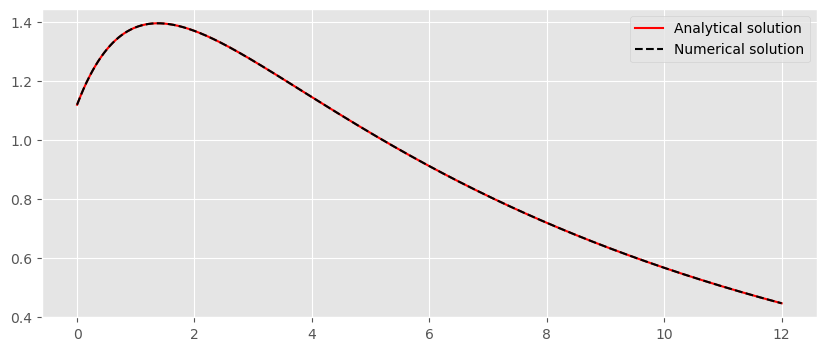

In [6]:
# Compare analytical and numerical solutions
C_ana = f(
    model.model_time_months,
    model.C_inst0,
    model.lake.tau * 12,
    model.K_L,
    model.C_bott0,
)

fig = plt.figure(figsize=(10, 4))
plt.plot(model.model_time_months, C_ana, "r-", label="Analytical solution")
plt.plot(
    model.model_time_months,
    model.model_delta_ca_mgpl,
    "k--",
    label="Numerical solution",
)
plt.legend()